<a href="https://colab.research.google.com/github/ZahraKheyrandish/Supply-Chain-Optimization-Inventory-Analysis/blob/main/Supply-Chain-Optimization-Inventory-Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
! pip install faker

In [47]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from scipy.stats import norm


In [48]:
fake = Faker('en_US')
Faker.seed(1234)
np.random.seed(1234)
random.seed(1234)


In [49]:
def get_seasonal_factor(date: datetime) -> float:
    """
    Calculates a seasonal factor based on the month.
    Boosts sales in winter months, slightly dips in summer.

    Args:
        date (datetime): The date for which to calculate the seasonal factor.

    Returns:
        float: The seasonal factor.
    """
    month = date.month
    if month in [12, 1, 2]:
        return 1.5
    elif month in [7, 8]:
        return 0.8
    return 1.0

In [50]:
def generate_products_df(num_products: int, faker_instance: Faker) -> pd.DataFrame:
    """
    Generates a DataFrame of synthetic product data for a pharmaceutical company.

    Args:
        num_products (int): The number of unique products to generate.
        faker_instance (Faker): An instance of the Faker library for generating names.

    Returns:
        pd.DataFrame: A DataFrame containing product_id, product_name, product_category,
                      unit_price, avg_shelf_life_days, and storage_conditions.
    """
    product_ids = [f'PROD_{i:05d}' for i in range(1, num_products + 1)]
    product_categories = [
        'Antibiotics', 'Pain Relievers', 'Anti-Inflammatories', 'Vitamins & Supplements',
        'Cardiovascular', 'Gastrointestinal', 'Respiratory', 'Neurological',
        'Dermatological', 'Ophthalmic & Otic', 'Diabetic Care', 'Hormonal',
        'Herbal Remedies', 'Disposable Medical Devices'
    ]
    product_names = []
    for _ in range(num_products):
        if random.random() < 0.7:
            product_names.append(f'{random.choice(["Tablet", "Capsule", "Syrup", "Ointment", "Ampoule", "Drop", "Cream"])} {faker_instance.word()} {faker_instance.word()}')
        else:
            product_names.append(f'{"".join(random.choices("ABCDEFGHIJKLMNOPQRSTUVWXYZ", k=2))}-{random.randint(100,999)} {random.choice(["mg", "g", "ml", "unit"])} {faker_instance.word()}')

    unit_prices = np.round(np.random.lognormal(mean=np.log(20), sigma=0.8, size=num_products), 2)
    unit_prices = np.maximum(unit_prices, 1.00)
    shelf_life_days = np.random.choice([365, 730, 1095, 1460, 1825], size=num_products, p=[0.1, 0.4, 0.3, 0.1, 0.1])
    storage_conditions = np.random.choice(['Room Temperature', 'Cold Storage', 'Protect from Light/Moisture', 'Refrigerated (2-8°C)'], size=num_products, p=[0.6, 0.2, 0.1, 0.1])

    products_df = pd.DataFrame({
        'product_id': product_ids,
        'product_name': product_names,
        'product_category': np.random.choice(product_categories, size=num_products),
        'unit_price': unit_prices,
        'avg_shelf_life_days': shelf_life_days,
        'storage_conditions': storage_conditions
    })
    products_df['product_category'] = products_df['product_category'].astype('category')
    products_df['storage_conditions'] = products_df['storage_conditions'].astype('category')
    return products_df


In [51]:
def generate_warehouses_df(num_warehouses: int) -> pd.DataFrame:
    """
    Generates a DataFrame of synthetic warehouse data.

    Args:
        num_warehouses (int): The number of warehouses to generate.

    Returns:
        pd.DataFrame: A DataFrame containing warehouse_id, warehouse_name, warehouse_city,
                      latitude, longitude, and capacity_units.
    """
    warehouse_ids = [f'WH_{i:02d}' for i in range(1, num_warehouses + 1)]
    warehouse_locations = {
        'Tehran': {'lat': 35.6892, 'lon': 51.3890}, 'Mashhad': {'lat': 36.2605, 'lon': 59.6168},
        'Isfahan': {'lat': 32.6546, 'lon': 51.6670}, 'Tabriz': {'lat': 38.0805, 'lon': 46.2918},
        'Shiraz': {'lat': 29.6065, 'lon': 52.5414}, 'Ahvaz': {'lat': 31.3204, 'lon': 48.6720},
        'Karaj': {'lat': 35.8322, 'lon': 50.9667}, 'Rasht': {'lat': 37.2752, 'lon': 49.5891},
        'Kerman': {'lat': 30.2832, 'lon': 57.0671}, 'Bandar Abbas': {'lat': 27.1887, 'lon': 56.2829}
    }
    warehouse_names = [f'Central Warehouse {city}' for city in warehouse_locations.keys()]
    warehouse_latitudes = [loc['lat'] for loc in warehouse_locations.values()]
    warehouse_longitudes = [loc['lon'] for loc in warehouse_locations.values()]
    capacity_units = np.random.randint(1_000_000, 5_000_000, size=num_warehouses)
    capacity_units[0] = np.random.randint(4_000_000, 7_000_000)

    warehouses_df = pd.DataFrame({
        'warehouse_id': warehouse_ids,
        'warehouse_name': warehouse_names,
        'warehouse_city': list(warehouse_locations.keys()),
        'latitude': warehouse_latitudes,
        'longitude': warehouse_longitudes,
        'capacity_units': capacity_units
    })
    warehouses_df['warehouse_city'] = warehouses_df['warehouse_city'].astype('category')
    return warehouses_df


In [52]:
def generate_suppliers_df(num_suppliers: int, faker_instance: Faker) -> pd.DataFrame:
    """
    Generates a DataFrame of synthetic supplier data.

    Args:
        num_suppliers (int): The number of suppliers to generate.
        faker_instance (Faker): An instance of the Faker library for generating names.

    Returns:
        pd.DataFrame: A DataFrame containing supplier_id, supplier_name, supplier_location,
                      avg_lead_time_days, and reliability_score.
    """
    supplier_ids = [f'SUP_{i:03d}' for i in range(1, num_suppliers + 1)]
    supplier_names = [faker_instance.company() for _ in range(num_suppliers)]
    supplier_locations = [faker_instance.city() for _ in range(num_suppliers)]
    avg_lead_time_days = np.random.randint(5, 30, size=num_suppliers)
    reliability_scores = np.round(np.random.uniform(0.7, 0.99, size=num_suppliers), 2)

    suppliers_df = pd.DataFrame({
        'supplier_id': supplier_ids,
        'supplier_name': supplier_names,
        'supplier_location': supplier_locations,
        'avg_lead_time_days': avg_lead_time_days,
        'reliability_score': reliability_scores
    })
    suppliers_df['supplier_location'] = suppliers_df['supplier_location'].astype('category')
    return suppliers_df

In [53]:
def generate_purchase_orders_df(num_purchase_orders: int, products_df: pd.DataFrame, suppliers_df: pd.DataFrame, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    """
    Generates a DataFrame of synthetic purchase order data.

    Args:
        num_purchase_orders (int): The number of purchase orders to generate.
        products_df (pd.DataFrame): DataFrame of product master data.
        suppliers_df (pd.DataFrame): DataFrame of supplier master data.
        start_date (datetime): The start date for generating POs.
        end_date (datetime): The end date for generating POs.

    Returns:
        pd.DataFrame: A DataFrame containing po_id, po_date, supplier_id, product_id,
                      ordered_quantity, unit_cost, expected_delivery_date, actual_delivery_date,
                      and delivery_status.
    """
    po_data = []
    for i in range(num_purchase_orders):
        po_id = f'PO_{i:05d}'
        po_date = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))

        product = products_df.sample(1).iloc[0]
        supplier = suppliers_df.sample(1, weights='reliability_score').iloc[0]

        base_quantity = np.random.randint(500, 5000)
        ordered_quantity = max(10, int(base_quantity / (product['unit_price'] / 10 + 1)))
        unit_cost = product['unit_price'] * np.random.uniform(0.5, 0.8)
        expected_delivery_date = po_date + timedelta(days=int(supplier['avg_lead_time_days']))

        delivery_delay_days = 0
        if random.random() < (1 - supplier['reliability_score']):
            delivery_delay_days = np.random.randint(1, 10)
            if random.random() < 0.2:
                delivery_delay_days = np.random.randint(10, 30)

        actual_delivery_date = expected_delivery_date + timedelta(days=int(delivery_delay_days))

        delivery_status = 'Delivered'
        if actual_delivery_date > end_date:
            delivery_status = 'Pending'
        elif actual_delivery_date > expected_delivery_date:
            delivery_status = 'Delayed'

        po_data.append({
            'po_id': po_id,
            'po_date': po_date,
            'supplier_id': supplier['supplier_id'],
            'product_id': product['product_id'],
            'ordered_quantity': ordered_quantity,
            'unit_cost': unit_cost,
            'expected_delivery_date': expected_delivery_date,
            'actual_delivery_date': actual_delivery_date,
            'delivery_status': delivery_status
        })

    purchase_orders_df = pd.DataFrame(po_data)
    purchase_orders_df['po_date'] = pd.to_datetime(purchase_orders_df['po_date'])
    purchase_orders_df['expected_delivery_date'] = pd.to_datetime(purchase_orders_df['expected_delivery_date'])
    purchase_orders_df['actual_delivery_date'] = pd.to_datetime(purchase_orders_df['actual_delivery_date'])
    purchase_orders_df['delivery_status'] = purchase_orders_df['delivery_status'].astype('category')
    return purchase_orders_df

In [54]:
def generate_customers_df(num_customers: int, faker_instance: Faker) -> pd.DataFrame:
    """
    Generates a DataFrame of synthetic customer (pharmacy) data.

    Args:
        num_customers (int): The number of customers to generate.
        faker_instance (Faker): An instance of the Faker library for generating names.

    Returns:
        pd.DataFrame: A DataFrame containing customer_id, customer_name, and customer_location.
    """
    customer_ids = [f'CUST_{i:04d}' for i in range(1, num_customers + 1)]
    customer_names = [faker_instance.company() + ' Pharmacy' for _ in range(num_customers)]
    customer_locations = [faker_instance.city() for _ in range(num_customers)]

    customers_df = pd.DataFrame({
        'customer_id': customer_ids,
        'customer_name': customer_names,
        'customer_location': customer_locations
    })
    customers_df['customer_location'] = customers_df['customer_location'].astype('category')
    return customers_df


In [55]:
def generate_sales_df(num_sales_records: int, products_df: pd.DataFrame, customers_df: pd.DataFrame, warehouses_df: pd.DataFrame, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    """
    Generates a DataFrame of synthetic sales data.

    Args:
        num_sales_records (int): The number of sales records to generate.
        products_df (pd.DataFrame): DataFrame of product master data.
        customers_df (pd.DataFrame): DataFrame of customer master data.
        warehouses_df (pd.DataFrame): DataFrame of warehouse master data.
        start_date (datetime): The start date for generating sales.
        end_date (datetime): The end date for generating sales.

    Returns:
        pd.DataFrame: A DataFrame containing sales_id, sales_date, customer_id, warehouse_id,
                      product_id, sold_quantity, sales_price, and delivery_time_hours.
    """
    sales_data = []
    for i in range(num_sales_records):
        sales_id = f'SALE_{i:06d}'
        sales_date = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))

        product = products_df.sample(1).iloc[0]
        customer = customers_df.sample(1).iloc[0]
        warehouse = warehouses_df.sample(1).iloc[0]

        base_sold_quantity = np.random.randint(5, 100)
        adjusted_sold_quantity = max(1, int(base_sold_quantity / (product['unit_price'] / 10 + 1)))

        seasonal_factor = get_seasonal_factor(sales_date)
        sold_quantity = max(1, int(adjusted_sold_quantity * seasonal_factor * np.random.uniform(0.8, 1.2)))

        sales_price = product['unit_price'] * sold_quantity
        delivery_time_hours = np.random.randint(4, 49)

        sales_data.append({
            'sales_id': sales_id,
            'sales_date': sales_date,
            'customer_id': customer['customer_id'],
            'warehouse_id': warehouse['warehouse_id'],
            'product_id': product['product_id'],
            'sold_quantity': sold_quantity,
            'sales_price': sales_price,
            'delivery_time_hours': delivery_time_hours
        })

    sales_df = pd.DataFrame(sales_data)
    sales_df['sales_date'] = pd.to_datetime(sales_df['sales_date'])
    return sales_df

In [56]:
def generate_returns_df(sales_df: pd.DataFrame, num_returns: int) -> pd.DataFrame:
    """
    Generates a DataFrame of synthetic product return data.

    Args:
        sales_df (pd.DataFrame): DataFrame of sales data.
        num_returns (int): The number of return records to generate.

    Returns:
        pd.DataFrame: A DataFrame containing return_id, sales_id, return_date, product_id,
                      warehouse_id, returned_quantity, and return_reason.
    """
    return_reasons = ['Damaged in transit', 'Incorrect item received', 'Customer changed mind', 'Expired product received']
    returns_data = []

    returned_sales = sales_df.sample(n=num_returns, replace=True).reset_index(drop=True) # Use replace=True if num_returns > len(sales_df)

    for index, row in returned_sales.iterrows():
        return_date = row['sales_date'] + timedelta(days=random.randint(1, 14))
        returned_quantity = random.randint(1, row['sold_quantity'])
        return_reason = random.choice(return_reasons)

        returns_data.append({
            'return_id': f'RET_{index:05d}',
            'sales_id': row['sales_id'],
            'return_date': return_date,
            'product_id': row['product_id'],
            'warehouse_id': row['warehouse_id'],
            'returned_quantity': returned_quantity,
            'return_reason': return_reason
        })

    returns_df = pd.DataFrame(returns_data)
    returns_df['return_date'] = pd.to_datetime(returns_df['return_date'])
    returns_df['return_reason'] = returns_df['return_reason'].astype('category')
    return returns_df

In [57]:
def simulate_inventory_and_waste(
    purchase_orders_df: pd.DataFrame,
    sales_df: pd.DataFrame,
    returns_df: pd.DataFrame,
    products_df: pd.DataFrame,
    warehouses_df: pd.DataFrame,
    start_date: datetime,
    end_date: datetime
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Simulates inventory levels over time, tracking receipts, issues, returns, and spoilage.
    Also generates records for stockouts and wasted inventory.

    Args:
        purchase_orders_df (pd.DataFrame): DataFrame of purchase orders.
        sales_df (pd.DataFrame): DataFrame of sales data.
        returns_df (pd.DataFrame): DataFrame of returns data.
        products_df (pd.DataFrame): DataFrame of product master data.
        warehouses_df (pd.DataFrame): DataFrame of warehouse master data.
        start_date (datetime): The overall start date for the simulation.
        end_date (datetime): The overall end date for the simulation.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
            - inventory_df: DataFrame of inventory snapshots over time.
            - waste_df: DataFrame of wasted (expired) inventory.
            - stockout_df: DataFrame of stockout events.
    """
    inventory_events = []

    # Add Receipts from Purchase Orders
    for _, row in purchase_orders_df.iterrows():
        if row['delivery_status'] == 'Delivered':
            expiry_date = row['actual_delivery_date'] + timedelta(days=int(products_df[products_df['product_id'] == row['product_id']]['avg_shelf_life_days'].iloc[0]))
            inventory_events.append({
                'event_date': row['actual_delivery_date'],
                'product_id': row['product_id'],
                'warehouse_id': random.choice(warehouses_df['warehouse_id'].tolist()),
                'quantity_change': row['ordered_quantity'],
                'event_type': 'Receipt',
                'batch_number': f'BATCH_{row["po_id"]}',
                'expiry_date': expiry_date
            })

    # Add Issues from Sales
    for _, row in sales_df.iterrows():
        inventory_events.append({
            'event_date': row['sales_date'],
            'product_id': row['product_id'],
            'warehouse_id': row['warehouse_id'],
            'quantity_change': -row['sold_quantity'],
            'event_type': 'Issue',
            'batch_number': None, # Batch determined during simulation
            'expiry_date': None # Expiry determined during simulation
        })


    for _, row in returns_df.iterrows():
        returned_product_shelf_life = int(products_df[products_df['product_id'] == row['product_id']]['avg_shelf_life_days'].iloc[0])
        expiry_date_return = row['return_date'] + timedelta(days=min(returned_product_shelf_life, 180))

        inventory_events.append({
            'event_date': row['return_date'],
            'product_id': row['product_id'],
            'warehouse_id': row['warehouse_id'],
            'quantity_change': row['returned_quantity'],
            'event_type': 'Return_Receipt',
            'batch_number': f'RET_BATCH_{row["return_id"]}',
            'expiry_date': expiry_date_return
        })

    inventory_events_df = pd.DataFrame(inventory_events)
    inventory_events_df['event_date'] = pd.to_datetime(inventory_events_df['event_date'])
    inventory_events_df = inventory_events_df.sort_values(by='event_date').reset_index(drop=True)
    inventory_events_df['event_type'] = inventory_events_df['event_type'].astype('category')


    inventory_records = []
    current_inventory = {}
    waste_records = []
    stockout_records = []

    all_dates = sorted(inventory_events_df['event_date'].unique())

    for current_date_np in all_dates:
        current_date = pd.to_datetime(current_date_np)


        expired_batches = []
        for (wh_id, prod_id, batch_num), details in list(current_inventory.items()):
            if details['quantity'] > 0 and details['expiry_date'] and details['expiry_date'] <= current_date:
                expired_batches.append(((wh_id, prod_id, batch_num), details['quantity']))

        for (wh_id, prod_id, batch_num), expired_qty in expired_batches:
            if current_inventory.get((wh_id, prod_id, batch_num), {}).get('quantity', 0) > 0:
                wasted_amount = current_inventory[(wh_id, prod_id, batch_num)]['quantity']
                waste_records.append({
                    'waste_date': current_date,
                    'warehouse_id': wh_id,
                    'product_id': prod_id,
                    'batch_number': batch_num,
                    'wasted_quantity': wasted_amount,
                    'reason': 'Expired'
                })
                current_inventory[(wh_id, prod_id, batch_num)]['quantity'] = 0

        # --- Process daily events (Receipts, Issues, Returns) ---
        daily_events = inventory_events_df[inventory_events_df['event_date'] == current_date].copy()

        for _, event in daily_events.iterrows():
            product_id = event['product_id']
            warehouse_id = event['warehouse_id']
            quantity_change = event['quantity_change']
            event_type = event['event_type']

            if event_type in ['Receipt', 'Return_Receipt']:
                batch_number = event['batch_number']
                expiry_date = event['expiry_date']
                key = (warehouse_id, product_id, batch_number)
                if key not in current_inventory:
                    current_inventory[key] = {'quantity': 0, 'expiry_date': expiry_date}
                current_inventory[key]['quantity'] += quantity_change
            elif event_type == 'Issue':
                remaining_to_sell = abs(quantity_change)

                available_batches = []
                for (wh_id, prod_id, batch_num), details in current_inventory.items():
                    if wh_id == warehouse_id and prod_id == product_id and details['quantity'] > 0:
                        available_batches.append((details['expiry_date'], batch_num, details['quantity']))

                available_batches.sort() # Sort by expiry date (FEFO)

                total_available_for_product = sum(current_inventory.get((wh_id, prod_id, b_num), {}).get('quantity', 0)
                                                  for (wh_id, prod_id, b_num), _ in current_inventory.items()
                                                  if wh_id == warehouse_id and prod_id == product_id)

                if remaining_to_sell > total_available_for_product:
                    stockout_quantity = remaining_to_sell - total_available_for_product
                    stockout_records.append({
                        'stockout_date': current_date,
                        'warehouse_id': warehouse_id,
                        'product_id': product_id,
                        'stockout_quantity': stockout_quantity
                    })
                    remaining_to_sell = total_available_for_product # Only sell what's available

                for expiry_date_batch, batch_num, batch_quantity in available_batches:
                    key = (warehouse_id, product_id, batch_num)
                    if remaining_to_sell <= 0:
                        break

                    if current_inventory[key]['quantity'] >= remaining_to_sell:
                        current_inventory[key]['quantity'] -= remaining_to_sell
                        remaining_to_sell = 0
                    else:
                        remaining_to_sell -= current_inventory[key]['quantity']
                        current_inventory[key]['quantity'] = 0

        # Record current inventory state for this date
        for (wh_id, prod_id, batch_num), details in current_inventory.items():
            if details['quantity'] > 0:
                inventory_records.append({
                    'snapshot_date': current_date,
                    'warehouse_id': wh_id,
                    'product_id': prod_id,
                    'batch_number': batch_num,
                    'quantity_on_hand': details['quantity'],
                    'expiry_date': details['expiry_date']
                })

    inventory_df = pd.DataFrame(inventory_records)
    inventory_df['snapshot_date'] = pd.to_datetime(inventory_df['snapshot_date'])
    inventory_df['expiry_date'] = pd.to_datetime(inventory_df['expiry_date'])
    inventory_df = inventory_df.sort_values(by=['snapshot_date', 'warehouse_id', 'product_id', 'expiry_date']).reset_index(drop=True)
    inventory_df = inventory_df.drop_duplicates(subset=['snapshot_date', 'warehouse_id', 'product_id', 'batch_number'], keep='last')

    waste_df = pd.DataFrame(waste_records)
    if not waste_df.empty:
        waste_df['waste_date'] = pd.to_datetime(waste_df['waste_date'])
        waste_df['reason'] = waste_df['reason'].astype('category')

    stockout_df = pd.DataFrame(stockout_records)
    if not stockout_df.empty:
        stockout_df['stockout_date'] = pd.to_datetime(stockout_df['stockout_date'])

    return inventory_df, waste_df, stockout_df


In [58]:

def perform_eda(products_df, warehouses_df, suppliers_df, customers_df, purchase_orders_df, sales_df, returns_df, inventory_df, waste_df, stockout_df):
    """
    Performs initial Exploratory Data Analysis (EDA) on the generated datasets.
    This function will contain various data visualizations and statistical summaries
    to understand patterns, trends, and identify potential issues in the supply chain.
    """
    print("\n--- Starting Exploratory Data Analysis (EDA) ---")

    # 1. Sales trends over time
    sales_by_date = sales_df.groupby('sales_date')['sold_quantity'].sum()
    plt.figure(figsize=(15, 6))
    sales_by_date.plot()
    plt.title('Total Sold Quantity Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Sold Quantity')
    plt.grid(True)
    plt.show()

    # 2. Top selling products
    top_products = sales_df.groupby('product_id')['sold_quantity'].sum().nlargest(10).reset_index()
    top_products_names = top_products.merge(products_df, on='product_id')['product_name']
    plt.figure(figsize=(15, 6))
    sns.barplot(x=top_products_names, y=top_products['sold_quantity'])
    plt.title('Top 10 Bestselling Products')
    plt.xlabel('Product')
    plt.ylabel('Total Sold Quantity')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 3. Waste analysis
    if not waste_df.empty:
        waste_by_reason = waste_df.groupby('reason')['wasted_quantity'].sum()
        plt.figure(figsize=(10, 6))
        sns.barplot(x=waste_by_reason.index, y=waste_by_reason.values)
        plt.title('Wasted Quantity by Reason')
        plt.xlabel('Reason')
        plt.ylabel('Wasted Quantity')
        plt.show()

    # 4. Stockout analysis
    if not stockout_df.empty:
        stockout_by_product = stockout_df.groupby('product_id')['stockout_quantity'].sum().nlargest(10).reset_index()
        stockout_products_names = stockout_by_product.merge(products_df, on='product_id')['product_name']
        plt.figure(figsize=(15, 6))
        sns.barplot(x=stockout_products_names, y=stockout_by_product['stockout_quantity'])
        plt.title('Top 10 Products with Most Stockouts')
        plt.xlabel('Product')
        plt.ylabel('Stockout Quantity')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

In [59]:
def perform_feature_engineering(products_df, warehouses_df, suppliers_df, customers_df, purchase_orders_df, sales_df, returns_df, inventory_df):
    """
    Performs feature engineering to create new, meaningful features for predictive modeling.
    This function will combine data from different DataFrames and derive new metrics.
    """


    daily_sales = sales_df.groupby('sales_date')['sold_quantity'].sum().reset_index()
    daily_sales.columns = ['ds', 'y']


    daily_sales['year'] = daily_sales['ds'].dt.year
    daily_sales['month'] = daily_sales['ds'].dt.month
    daily_sales['dayofweek'] = daily_sales['ds'].dt.dayofweek


    daily_sales['lag_1'] = daily_sales['y'].shift(1)


    daily_sales['rolling_7'] = daily_sales['y'].shift(1).rolling(window=7).mean()

    print("\nDaily sales with engineered features:")
    print(daily_sales.head(10))


    sales_features_df = sales_df.copy()
    sales_features_df = sales_features_df.merge(products_df[['product_id', 'product_category', 'avg_shelf_life_days']], on='product_id', how='left')
    sales_features_df = sales_features_df.merge(warehouses_df[['warehouse_id', 'warehouse_city']], on='warehouse_id', how='left')

    print("\nSales DataFrame with merged product and warehouse features:")
    print(sales_features_df[['sales_id', 'sales_date', 'product_category', 'warehouse_city']].head())


    return products_df, warehouses_df, suppliers_df, customers_df, purchase_orders_df, sales_df, returns_df, inventory_df


In [60]:
def perform_demand_forecasting(sales_df, products_df):
    """
    Develops and evaluates models for demand forecasting.
    This function would involve time series analysis techniques or machine learning models.
    """


    sample_product_id = sales_df.groupby('product_id')['sold_quantity'].sum().nlargest(1).index[0]
    product_sales = sales_df[sales_df['product_id'] == sample_product_id]


    daily_sales = product_sales.groupby('sales_date')['sold_quantity'].sum().reset_index()
    daily_sales.columns = ['ds', 'y']
    daily_sales = daily_sales.set_index('ds').resample('D').sum().fillna(0).reset_index()


    daily_sales['year'] = daily_sales['ds'].dt.year
    daily_sales['month'] = daily_sales['ds'].dt.month
    daily_sales['dayofweek'] = daily_sales['ds'].dt.dayofweek
    daily_sales['lag_1'] = daily_sales['y'].shift(1).fillna(0)


    X = daily_sales[['year', 'month', 'dayofweek', 'lag_1']]
    y = daily_sales['y']


    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]


    lgbm = lgb.LGBMRegressor(random_state=1234)
    lgbm.fit(X_train, y_train)


    predictions = lgbm.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    print(f"\nLightGBM Model MAE for product {sample_product_id}: {mae:.2f}")

    # Plot results
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test.values, label='Actual Sales')
    plt.plot(y_test.index, predictions, label='Forecasted Sales')
    plt.title(f'Demand Forecast for Product {sample_product_id}')
    plt.xlabel('Date')
    plt.ylabel('Sold Quantity')
    plt.legend()
    plt.show()


    return lgbm, X_test, y_test

In [61]:
def perform_inventory_optimization(products_df, sales_df, lgbm_model, X_test, y_test):
    """
    Develops strategies and models for inventory optimization.
    This function would use forecasted demand, lead times, and costs to determine optimal reorder points and quantities.
    """


    sample_product_id = products_df['product_id'].sample(1).iloc[0]
    product_details = products_df[products_df['product_id'] == sample_product_id].iloc[0]
    avg_daily_demand = y_test.mean()
    lead_time = random.choice(range(5, 30))


    std_dev_demand = y_test.std()
    safety_stock = 1.645 * std_dev_demand * np.sqrt(lead_time)


    rop = (avg_daily_demand * lead_time) + safety_stock


    ordering_cost = 100
    holding_cost = product_details['unit_price'] * 0.20
    annual_demand = avg_daily_demand * 365
    eoq = np.sqrt((2 * annual_demand * ordering_cost) / holding_cost)

    print(f"\nInventory Optimization Results for Product {sample_product_id}:")
    print(f"   Average Daily Demand: {avg_daily_demand:.2f} units")
    print(f"   Assumed Lead Time: {lead_time} days")
    print(f"   Safety Stock (95% service level): {safety_stock:.2f} units")
    print(f"   Reorder Point (ROP): {rop:.2f} units")
    print(f"   Economic Order Quantity (EOQ): {eoq:.2f} units")


In [62]:
def perform_business_impact_analysis(waste_df, stockout_df, products_df):
    """
    Analyzes the business impact of the optimized supply chain, quantifying cost savings and efficiency gains.
    """



    if not waste_df.empty:
        wasted_cost = waste_df.merge(products_df[['product_id', 'unit_price']], on='product_id')
        wasted_cost['total_cost'] = wasted_cost['wasted_quantity'] * wasted_cost['unit_price']
        total_wasted_cost = wasted_cost['total_cost'].sum()
        print(f"\nEstimated total cost of wasted (expired) inventory: ${total_wasted_cost:.2f}")


    if not stockout_df.empty:
        stockout_cost = stockout_df.merge(products_df[['product_id', 'unit_price']], on='product_id')
        stockout_cost['lost_revenue'] = stockout_cost['stockout_quantity'] * stockout_cost['unit_price']
        total_lost_revenue = stockout_cost['lost_revenue'].sum()
        print(f"Estimated total lost revenue due to stockouts: ${total_lost_revenue:.2f}")


    if 'total_wasted_cost' in locals() and 'total_lost_revenue' in locals():
        potential_waste_savings = total_wasted_cost * 0.10
        potential_stockout_savings = total_lost_revenue * 0.20
        total_potential_savings = potential_waste_savings + potential_stockout_savings
        print(f"\nPotential Annual Savings from Optimization (estimated):")
        print(f"   Savings from reducing waste by 10%: ${potential_waste_savings:.2f}")
        print(f"   Savings from reducing stockouts by 20%: ${potential_stockout_savings:.2f}")
        print(f"   **Total Potential Savings: ${total_potential_savings:.2f}**")


In [63]:
def data_validation(products_df, sales_df):
    """
    Performs basic statistical validation of the generated data to ensure realism.
    """



    plt.figure(figsize=(10, 6))
    sns.histplot(products_df['unit_price'], bins=50, kde=True)
    plt.title('Distribution of Product Unit Prices')
    plt.xlabel('Unit Price')
    plt.ylabel('Frequency')
    plt.show()


    plt.figure(figsize=(10, 6))
    sns.histplot(sales_df['sold_quantity'], bins=50, kde=True)
    plt.title('Distribution of Sold Quantities')
    plt.xlabel('Sold Quantity')
    plt.ylabel('Frequency')
    plt.show()


    sales_by_date = sales_df.groupby('sales_date')['sold_quantity'].sum()
    plt.figure(figsize=(15, 6))
    sales_by_date.plot()
    plt.title('Overall Sales Trend (Sanity Check for Seasonality)')
    plt.xlabel('Date')
    plt.ylabel('Total Sold Quantity')
    plt.show()


In [64]:
def risk_and_limitations_analysis():
    """
    Discusses the limitations and risks of the current model and suggests future improvements.
    """

    print("\n**1. Limitations:**")
    print("   - The data is synthetic and may not capture all the nuances of a real-world pharmaceutical supply chain.")
    print("   - Human factors in ordering, supplier negotiations, and unexpected market events are simplified or not included.")

    print("\n**2. Model Simplifications:**")
    print("   - The inventory simulation uses a simplified FEFO (First Expired, First Out) logic. Real systems can be more complex.")
    print("   - Lead times and supplier reliability are fixed or random. Real-world values are dynamic and influenced by many factors.")
    print("   - Costs (holding, ordering, stockout) are assumptions. Accurate costs are crucial for real optimization.")

    print("\n**3. Future Improvements:**")
    print("   - Integrating external data sources like market trends, weather data, and disease outbreaks for better demand forecasting.")
    print("   - Using more advanced time series models (e.g., Prophet, LSTM) for forecasting.")
    print("   - Developing a multi-echelon optimization model to manage inventory across all warehouses simultaneously.")
    print("   - Incorporating network optimization algorithms for efficient routing and warehouse placement.")



**Phase 1: Data Generation, Validation & Preparation**
products_df
   product_id           product_name        product_category  unit_price  \
0  PROD_00001         LA-926 mg star       Ophthalmic & Otic       29.16   
1  PROD_00002         Tablet let but  Vitamins & Supplements        7.71   
2  PROD_00003  Syrup account believe                Hormonal       62.92   
3  PROD_00004     Tablet whether yes           Diabetic Care       15.57   
4  PROD_00005      AQ-595 unit wrong           Diabetic Care       11.24   

   avg_shelf_life_days           storage_conditions  
0                 1095             Room Temperature  
1                 1460  Protect from Light/Moisture  
2                 1095             Room Temperature  
3                  730             Room Temperature  
4                 1095                 Cold Storage  

warehouses_df
  warehouse_id             warehouse_name warehouse_city  latitude  longitude  \
0        WH_01   Central Warehouse Tehran         Tehra

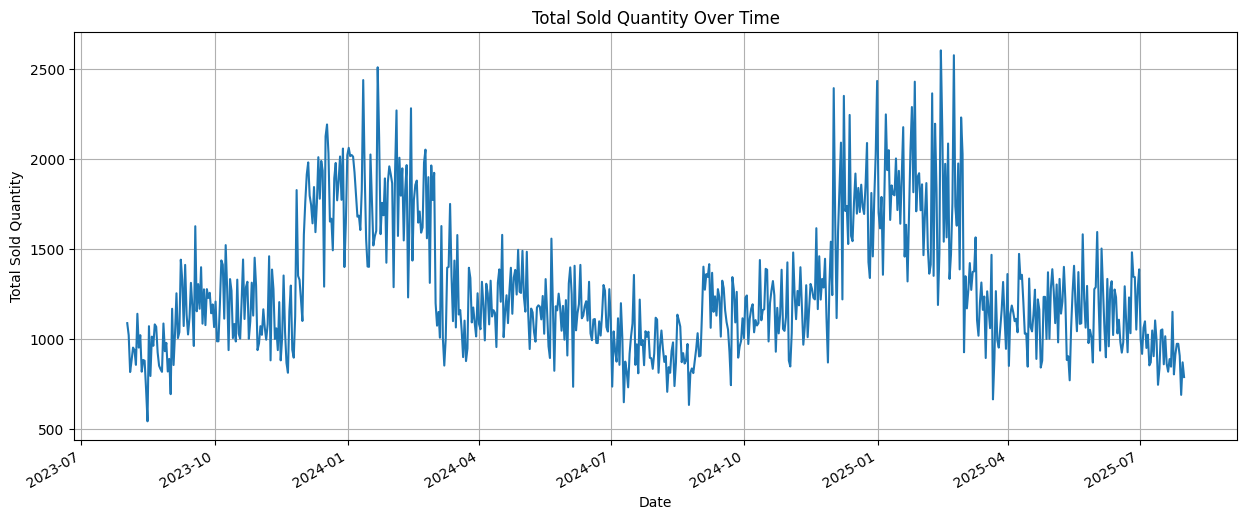

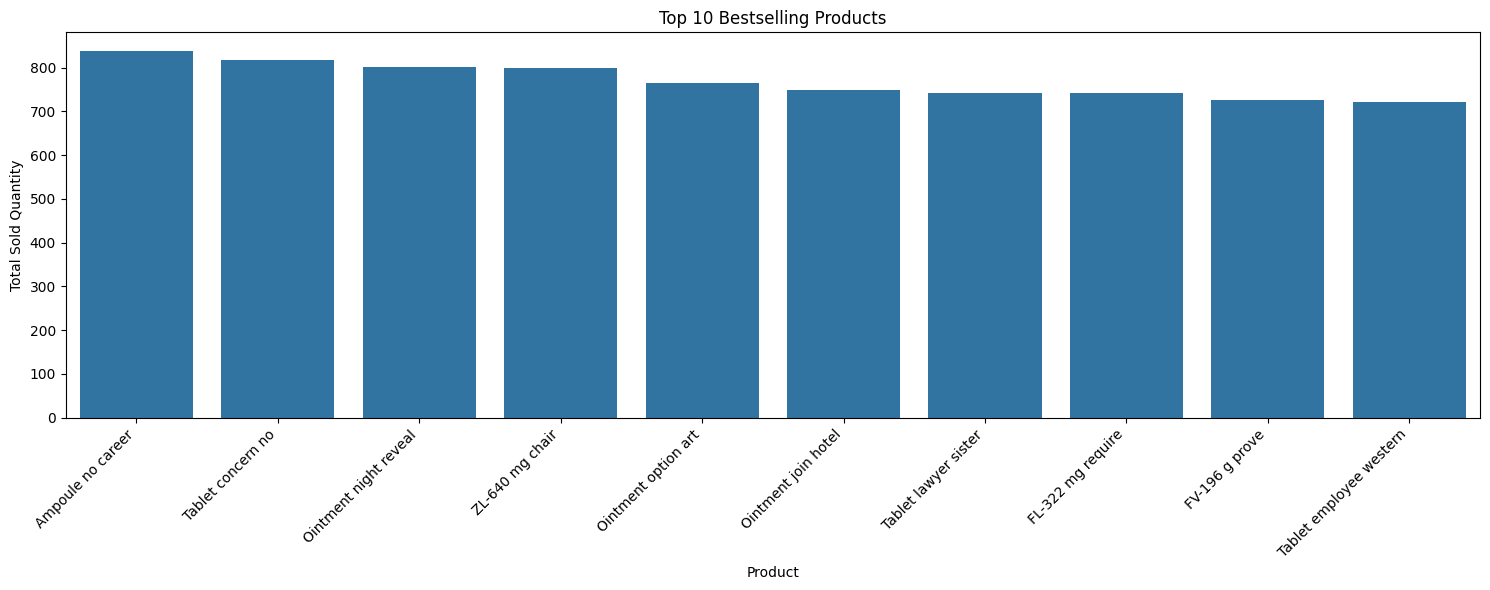

/tmp/ipython-input-821009554.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  waste_by_reason = waste_df.groupby('reason')['wasted_quantity'].sum()


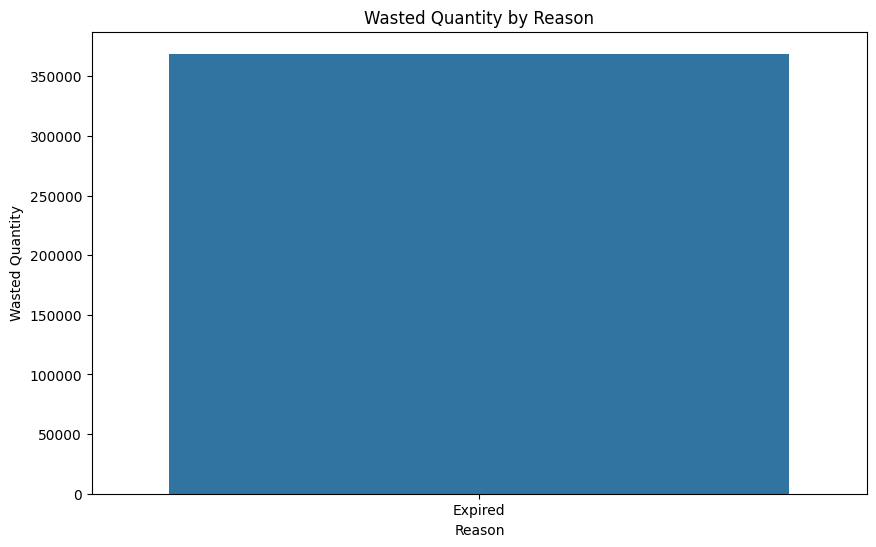

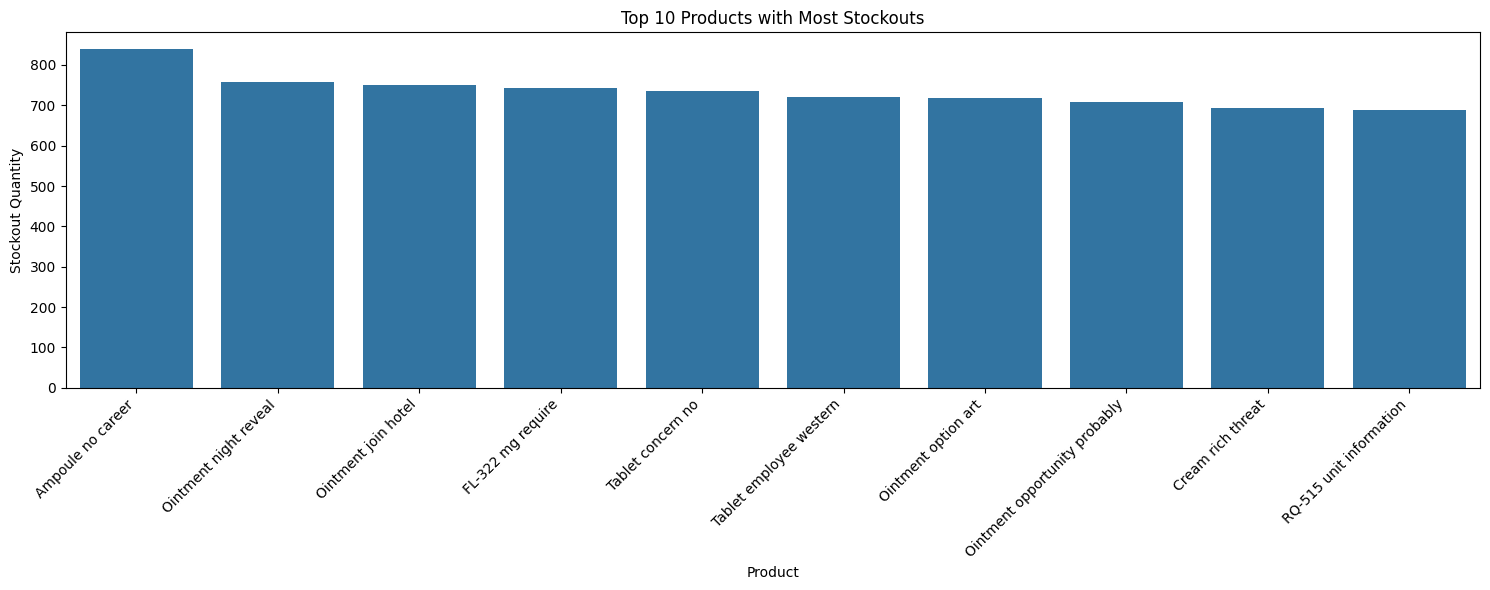


Daily sales with engineered features:
                          ds     y  year  month  dayofweek   lag_1   rolling_7
0 2023-08-01 16:23:50.335296  1088  2023      8          1     NaN         NaN
1 2023-08-02 16:23:50.335296  1021  2023      8          2  1088.0         NaN
2 2023-08-03 16:23:50.335296   816  2023      8          3  1021.0         NaN
3 2023-08-04 16:23:50.335296   881  2023      8          4   816.0         NaN
4 2023-08-05 16:23:50.335296   952  2023      8          5   881.0         NaN
5 2023-08-06 16:23:50.335296   938  2023      8          6   952.0         NaN
6 2023-08-07 16:23:50.335296   856  2023      8          0   938.0         NaN
7 2023-08-08 16:23:50.335296  1140  2023      8          1   856.0  936.000000
8 2023-08-09 16:23:50.335296   952  2023      8          2  1140.0  943.428571
9 2023-08-10 16:23:50.335296  1021  2023      8          3   952.0  933.571429

Sales DataFrame with merged product and warehouse features:
      sales_id                 

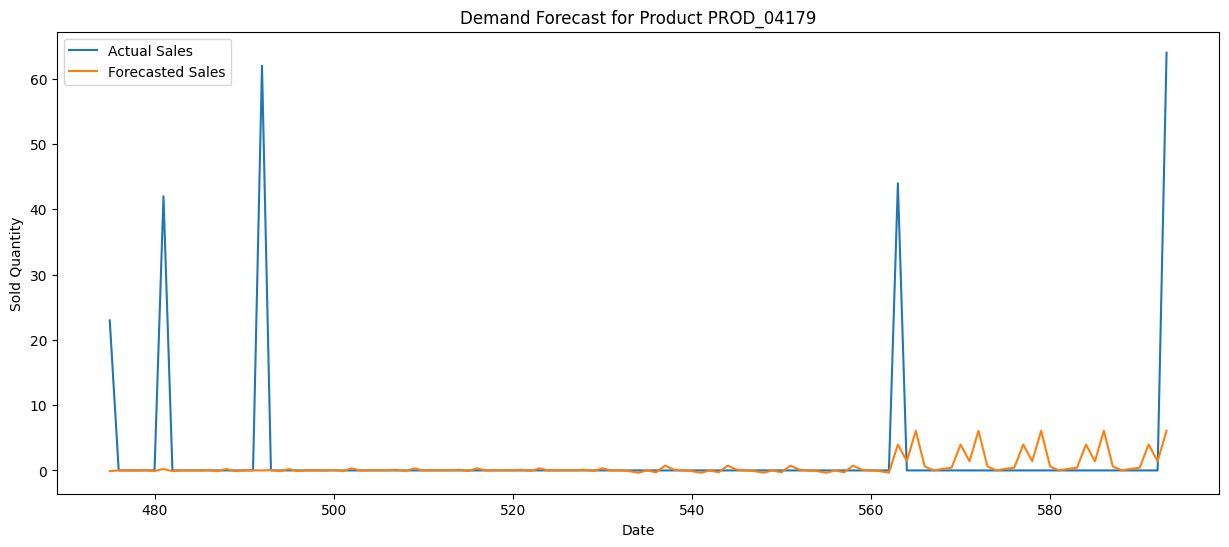


Inventory Optimization Results for Product PROD_03514:
   Average Daily Demand: 1.97 units
   Assumed Lead Time: 12 days
   Safety Stock (95% service level): 56.75 units
   Reorder Point (ROP): 80.45 units
   Economic Order Quantity (EOQ): 194.88 units

Estimated total cost of wasted (expired) inventory: $7121246.95
Estimated total lost revenue due to stockouts: $15864914.05

Potential Annual Savings from Optimization (estimated):
   Savings from reducing waste by 10%: $712124.70
   Savings from reducing stockouts by 20%: $3172982.81
   **Total Potential Savings: $3885107.51**

**Phase 3: Risk & Limitations Analysis**

**1. Limitations:**
   - The data is synthetic and may not capture all the nuances of a real-world pharmaceutical supply chain.
   - Human factors in ordering, supplier negotiations, and unexpected market events are simplified or not included.

**2. Model Simplifications:**
   - The inventory simulation uses a simplified FEFO (First Expired, First Out) logic. Real syste

In [65]:
if __name__ == '__main__':

    NUM_PRODUCTS = 5000
    NUM_WAREHOUSES = 10
    NUM_SUPPLIERS = 50
    NUM_CUSTOMERS = 1000
    NUM_PURCHASE_ORDERS = 10000
    NUM_SALES_RECORDS = 50000
    NUM_RETURNS = int(NUM_SALES_RECORDS * 0.05)


    START_DATE = datetime.now() - timedelta(days=2*365)
    END_DATE = datetime.now()

    print("\n**Phase 1: Data Generation, Validation & Preparation**")


    products_df = generate_products_df(NUM_PRODUCTS, fake)
    print("products_df")
    print(products_df.head())

    warehouses_df = generate_warehouses_df(NUM_WAREHOUSES)
    print("\nwarehouses_df")
    print(warehouses_df.head())

    suppliers_df = generate_suppliers_df(NUM_SUPPLIERS, fake)
    print("\nsuppliers_df")
    print(suppliers_df.head())

    purchase_orders_df = generate_purchase_orders_df(NUM_PURCHASE_ORDERS, products_df, suppliers_df, START_DATE, END_DATE)
    print("\npurchase_orders_df")
    print(purchase_orders_df.head())

    customers_df = generate_customers_df(NUM_CUSTOMERS, fake)
    print("\ncustomers_df")
    print(customers_df.head())

    sales_df = generate_sales_df(NUM_SALES_RECORDS, products_df, customers_df, warehouses_df, START_DATE, END_DATE)
    print("\nsales_df")
    print(sales_df.head())

    returns_df = generate_returns_df(sales_df, NUM_RETURNS)
    print("\nreturns_df")
    print(returns_df.head())

    inventory_df, waste_df, stockout_df = simulate_inventory_and_waste(purchase_orders_df, sales_df, returns_df, products_df, warehouses_df, START_DATE, END_DATE)
    print("\ninventory_df")
    print(inventory_df.head())

    if not waste_df.empty:
        print("\nwaste_df (Spoilage)")
        print(waste_df.head())
    else:
        print("\nNo Waste (Spoilage) records generated.")

    if not stockout_df.empty:
        print("\nstockout_df")
        print(stockout_df.head())
    else:
        print("\nNo Stockout records generated.")

        products_df.to_csv('products.csv', index=False)
    warehouses_df.to_csv('warehouses.csv', index=False)
    suppliers_df.to_csv('suppliers.csv', index=False)
    customers_df.to_csv('customers.csv', index=False)
    purchase_orders_df.to_csv('purchase_orders.csv', index=False)
    sales_df.to_csv('sales.csv', index=False)
    returns_df.to_csv('returns.csv', index=False)
    inventory_df.to_csv('inventory.csv', index=False)
    waste_df.to_csv('waste.csv', index=False)
    stockout_df.to_csv('stockouts.csv', index=False)

    products_df.to_parquet('products.parquet', index=False)
    warehouses_df.to_parquet('warehouses.parquet', index=False)
    suppliers_df.to_parquet('suppliers.parquet', index=False)
    customers_df.to_parquet('customers.parquet', index=False)
    purchase_orders_df.to_parquet('purchase_orders.parquet', index=False)
    sales_df.to_parquet('sales.parquet', index=False)
    returns_df.to_parquet('returns.parquet', index=False)
    inventory_df.to_parquet('inventory.parquet', index=False)
    waste_df.to_parquet('waste.parquet', index=False)
    stockout_df.to_parquet('stockouts.parquet', index=False)


    print("\n**Phase 2: EDA, Modeling & Optimization**")
    perform_eda(products_df, warehouses_df, suppliers_df, customers_df, purchase_orders_df, sales_df, returns_df, inventory_df, waste_df, stockout_df)

    products_df, warehouses_df, suppliers_df, customers_df, purchase_orders_df, sales_df, returns_df, inventory_df = \
        perform_feature_engineering(products_df, warehouses_df, suppliers_df, customers_df, purchase_orders_df, sales_df, returns_df, inventory_df)

    lgbm_model, X_test, y_test = perform_demand_forecasting(sales_df, products_df)

    perform_inventory_optimization(products_df, sales_df, lgbm_model, X_test, y_test)

    perform_business_impact_analysis(waste_df, stockout_df, products_df)

    print("\n**Phase 3: Risk & Limitations Analysis**")
    risk_and_limitations_analysis()


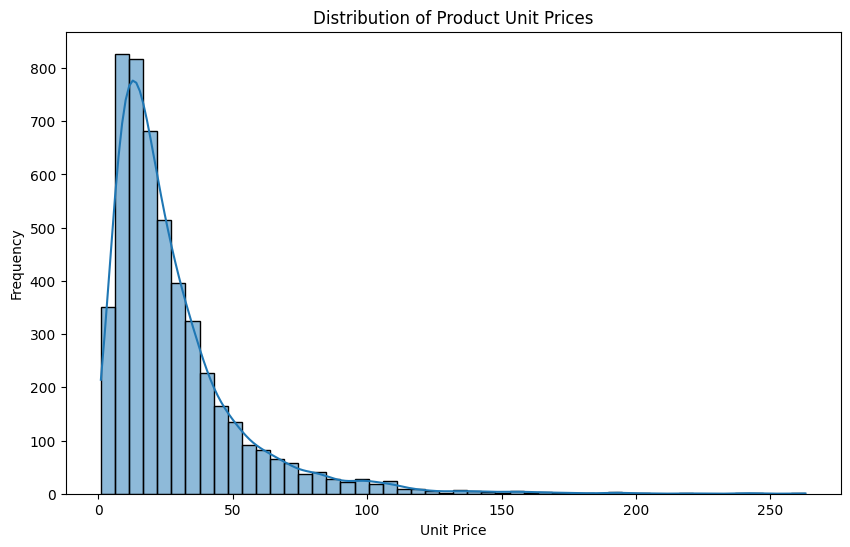

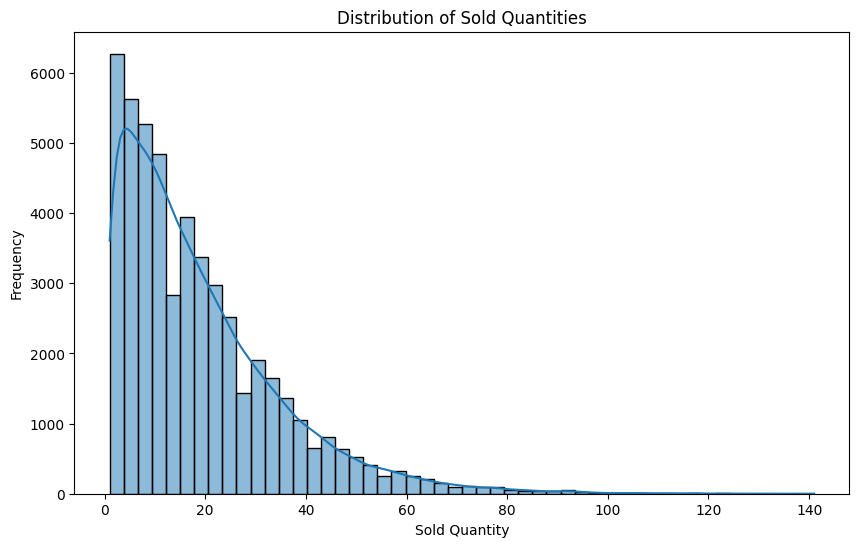

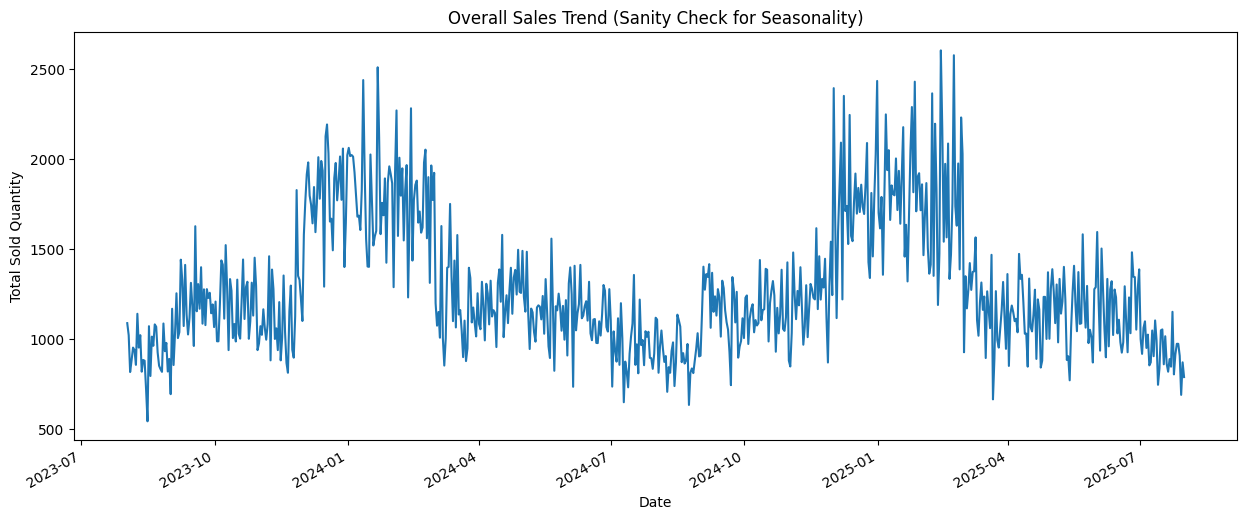

In [66]:
 data_validation(products_df, sales_df)